<a href="https://colab.research.google.com/github/mcatrinque/spam_sms_classifiers/blob/main/classificacao_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Estudo de caso 5 do curso de Introduação à Ciência de Dados Aplicada à Cibersegurança

#Importando bibliotecas básicas

import numpy as np # vetores e matrizes
import pandas as pd # processamento dos dados, arquivo CSV I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import nltk
import re
import string

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn import metrics

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [ ]:
# Importando a base de dados para o pandas

sms = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1,
                  names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Explorando a Base de Dados

### Tipos de dados

In [ ]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Levantamentos estatísticos básicos

In [ ]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### Quantitativo de palavras e sentenças no corpo das mensagens


In [ ]:
sms['qtd_palavras'] = sms['message'].apply(lambda x:len(nltk.word_tokenize(x)))
sms['qtd_frases'] = sms['message'].apply(lambda x:len(nltk.sent_tokenize(x)))
sms.head()

,label,message,qtd_palavras,qtd_frases
0,ham,"Go until jurong point, crazy.. Available only ...",23,2
1,ham,Ok lar... Joking wif u oni...,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,37,2
3,ham,U dun say so early hor... U c already then say...,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",15,1


### Distribuição das mensagens entre os rótulos

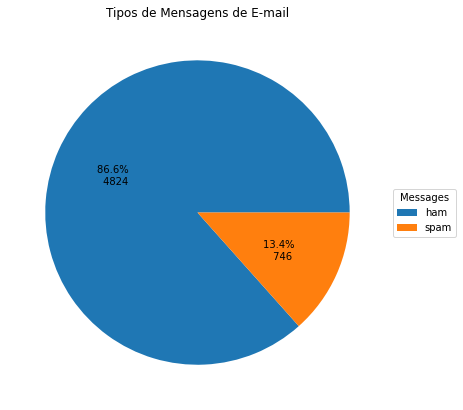

In [ ]:
# Inserindo porcentagem e quantidade
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}% \n {:d}".format(pct, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
mails = sms.label.copy().value_counts()
wedges, texts, autotexts = ax.pie(mails, autopct = lambda pct: func(pct, mails))
ax.set_title('Tipos de Mensagens de E-mail')

# Adicionando legenda
ax.legend(wedges, ['ham', 'spam'],
          title ="Messages",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.show()

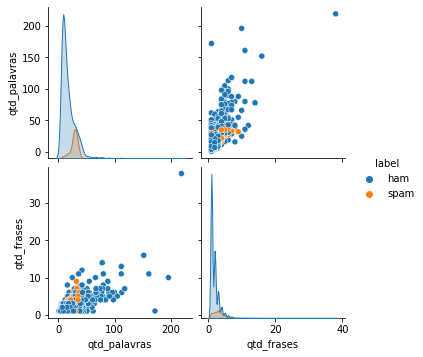

In [ ]:
sns.pairplot(sms,hue='label')

## Tratamento de Dados

### Excluindo duplicatas e dados nulos

In [ ]:
#Eliminando dados irrelevantes
sms = sms.dropna()
sms = sms.drop_duplicates()

### Remodelando as mensagens para obter apenas radicais relevantes


In [ ]:
def clean_text(msg):
    #removendo caixa alta
    msg = str(msg).lower()
    #removendo digitos
    msg = ''.join([i for i in msg if not i.isdigit()])
    #removendo pontuacao
    msg = "".join([i for i in msg if i not in string.punctuation])
    #removendo stopwords
    msg = " ".join(msg for msg in msg.split() if msg not in nltk.corpus.stopwords.words("english"))
    #retorna a palavra base
    msg = "".join([nltk.stem.WordNetLemmatizer().lemmatize(word) for word in msg])
    #removendo URLs
    msg = re.sub(r'\s*https?:\s*', '', msg)
    return msg

sms['message'] = sms['message'].apply(clean_text)
sms.head()

,label,message,qtd_palavras,qtd_frases
0,ham,go jurong point crazy available bugis n great ...,23,2
1,ham,ok lar joking wif u oni,8,2
2,spam,free entry wkly comp win fa cup final tkts st ...,37,2
3,ham,u dun say early hor u c already say,13,1
4,ham,nah dont think goes usf lives around though,15,1


### Ocorrências de palavras mais comums nas mensagens

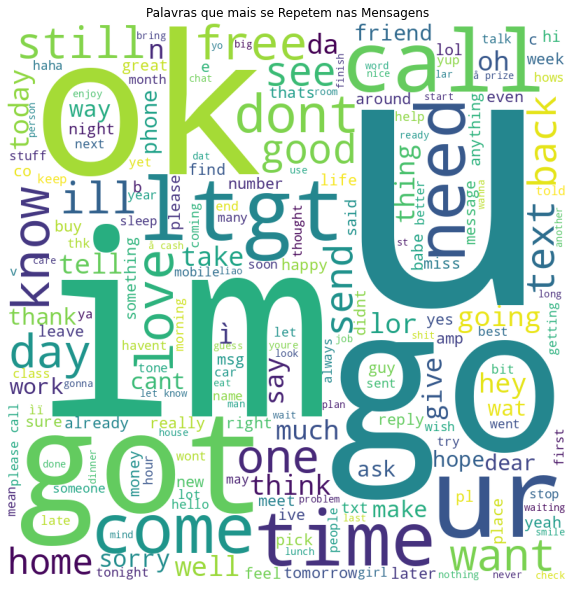

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)

for val in sms['message']:
    val = str(val)
    tokens = val.split()
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Palavras que mais se Repetem nas Mensagens")
plt.tight_layout(pad = 0)

plt.show()

## Treinamento de Modelos

### Preparação dos Dados

In [ ]:
sms.label = sms.label.map({"ham":0, "spam":1})

In [ ]:
#Dividindo a base em treino e teste
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(sms.message,
                                                                            sms.label,
                                                                            test_size=0.2)

In [ ]:
# Criando o documento de treino

from sklearn.feature_extraction.text import CountVectorizer

couvec = CountVectorizer()
couvec.fit(features_train)

CountVectorizer()

In [ ]:
# número de características ou tokens
trained_features = couvec.get_feature_names()
print("Número de características vetorizadas:", len(trained_features))
print("Exemplos de características treinadas:", trained_features[1:10])

Número de características vetorizadas: 7415
Exemplos de características treinadas: ['aah', 'aaniye', 'aaooooright', 'aathilove', 'aathiwhere', 'ab', 'abbey', 'abdomen', 'abeg']


In [ ]:
# tokenized train documents

dtm_train = couvec.fit_transform(features_train)
print("Shape of dtm_train:", dtm_train.shape)
print(dtm_train[0:2]) # first two rows of sparse matrix

Shape of dtm_train: (4135, 7415)
  (0, 2776)	1
  (0, 614)	1
  (0, 3451)	1
  (0, 4527)	1
  (0, 4042)	1
  (0, 443)	1
  (0, 758)	1
  (1, 2990)	1
  (1, 4055)	1
  (1, 861)	1
  (1, 6969)	1


In [ ]:
# tokenized test documents

dtm_test = couvec.transform(features_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1034, 7415)


### Multimodal Naive Bayes

In [ ]:
# Construíndo e avaliando o modelo

# Multimodal Naive Bayes
# O classificador multimodal Naive Bays é útil para classificar características discretas.
# (e.g., número de palavras para classificação de textos).
# A distribuição multimodal requer geralmente contadores inteiros como features.

# Importando e instanciando o modelo Nayve Bayes Multimodal
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
# Treinando o modelo
nb.fit(dtm_train, labels_train)
# Fazendo predições
labels_pred = nb.predict(dtm_test)

In [ ]:
nb_metrics = []
nb_metrics.append(metrics.accuracy_score(labels_test, labels_pred))
# Percentagem do total de spams detectados i.e.recall
nb_metrics.append(metrics.recall_score(labels_test, labels_pred))
# Percentagem das predições positivas (spams) corretas, i.e. precisão
nb_metrics.append(metrics.precision_score(labels_test, labels_pred))
nb_metrics.append(metrics.f1_score(labels_test, labels_pred))

In [ ]:
# Criando a matrix de confusão para precisão e recall (essas são duas outrss métricas de avaliação)
disp = []
disp.append(metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(labels_test, labels_pred),display_labels=nb.classes_))

In [ ]:
print("Ordem das classes no predict_proba:", nb.classes_)
print("Exemplos de probabilidades de classes:", nb.predict_proba(dtm_test)[0])

Ordem das classes no predict_proba: [0 1]
Exemplos de probabilidades de classes: [0.99456199 0.00543801]


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(dtm_train, labels_train)
labels_pred = rf.predict(dtm_test)

In [ ]:
rf_metrics = []
rf_metrics.append(metrics.accuracy_score(labels_test, labels_pred))
rf_metrics.append(metrics.recall_score(labels_test, labels_pred))
rf_metrics.append(metrics.precision_score(labels_test, labels_pred))
rf_metrics.append(metrics.f1_score(labels_test, labels_pred))

In [ ]:
disp.append(metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(labels_test, labels_pred),display_labels=rf.classes_))

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(dtm_train, labels_train)
labels_pred = dt.predict(dtm_test)

In [ ]:
dt_metrics = []
dt_metrics.append(metrics.accuracy_score(labels_test, labels_pred))
dt_metrics.append(metrics.recall_score(labels_test, labels_pred))
dt_metrics.append(metrics.precision_score(labels_test, labels_pred))
dt_metrics.append(metrics.f1_score(labels_test, labels_pred))

In [ ]:
disp.append(metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(labels_test, labels_pred),display_labels=dt.classes_))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(solver='liblinear')
lr.fit(dtm_train, labels_train)
labels_pred = lr.predict(dtm_test)

In [ ]:
lr_metrics = []
lr_metrics.append(metrics.accuracy_score(labels_test, labels_pred))
lr_metrics.append(metrics.recall_score(labels_test, labels_pred))
lr_metrics.append(metrics.precision_score(labels_test, labels_pred))
lr_metrics.append(metrics.f1_score(labels_test, labels_pred))

In [ ]:
disp.append(metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(labels_test, labels_pred),display_labels=lr.classes_))

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)
gb.fit(dtm_train, labels_train)
labels_pred = gb.predict(dtm_test)

In [ ]:
gb_metrics = []
gb_metrics.append(metrics.accuracy_score(labels_test, labels_pred))
gb_metrics.append(metrics.recall_score(labels_test, labels_pred))
gb_metrics.append(metrics.precision_score(labels_test, labels_pred))
gb_metrics.append(metrics.f1_score(labels_test, labels_pred))

In [ ]:
disp.append(metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(labels_test, labels_pred),display_labels=lr.classes_))

### SVM

In [ ]:
from sklearn import svm
sv = svm.SVC(kernel='rbf')
sv.fit(dtm_train, labels_train)
labels_pred = sv.predict(dtm_test)

In [ ]:
sv_metrics = []
sv_metrics.append(metrics.accuracy_score(labels_test, labels_pred))
sv_metrics.append(metrics.recall_score(labels_test, labels_pred))
sv_metrics.append(metrics.precision_score(labels_test, labels_pred))
sv_metrics.append(metrics.f1_score(labels_test, labels_pred))

In [ ]:
disp.append(metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(labels_test, labels_pred),display_labels=sv.classes_))

## Análise de Resultados

### Métricas de avaliação de desempenho dos modelos

In [ ]:
model_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
model_names = ['NaiveBayes', 'RandomForest', 'DecisionTree', 'LogisticRegression', 'GradientBosting', 'SVM']
model_metrics.loc[1] = nb_metrics
model_metrics.loc[2] = rf_metrics
model_metrics.loc[3] = dt_metrics
model_metrics.loc[4] = lr_metrics
model_metrics.loc[5] = gb_metrics
model_metrics.loc[6] = sv_metrics

model_metrics = model_metrics * 100
model_metrics['Models'] = model_names
temp_cols=model_metrics.columns.tolist()
new_cols=temp_cols[-1:] + temp_cols[:-1]
model_metrics=model_metrics[new_cols]
model_metrics

,Models,Accuracy,Precision,Recall,F1-Score
1,NaiveBayes,98.065764,90.714286,94.776119,92.700730
2,RandomForest,97.292070,80.000000,100.000000,88.888889
3,DecisionTree,95.357834,77.857143,86.507937,81.954887
4,LogisticRegression,97.775629,84.285714,99.159664,91.119691
5,GradientBosting,97.001934,80.714286,96.581197,87.937743
6,SVM,96.905222,78.571429,98.214286,87.301587


### Comparação do desempenho das métricas entre os modelos

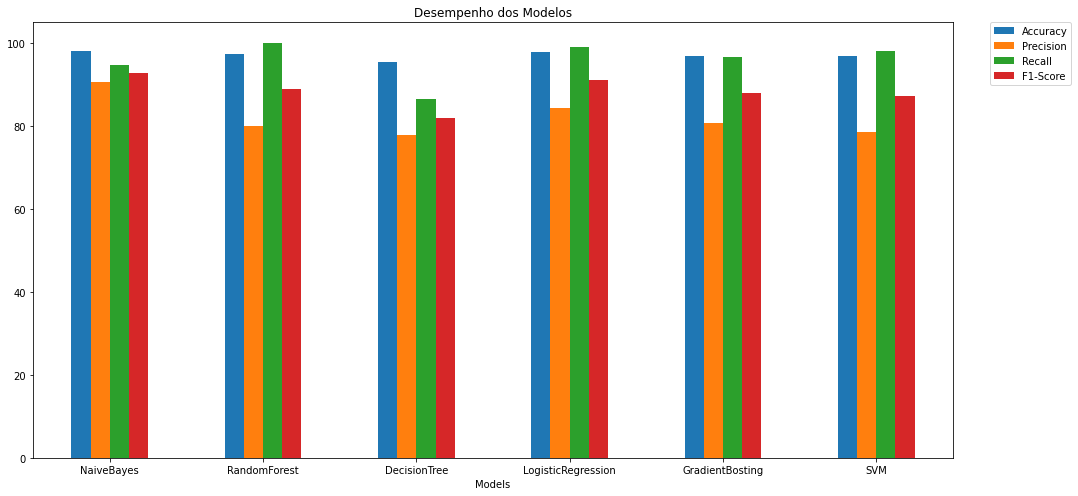

In [ ]:
plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True

model_metrics.plot.bar(title='Desempenho dos Modelos', x='Models', rot=0)

plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.0)
plt.show()

### Matriz de Confusão

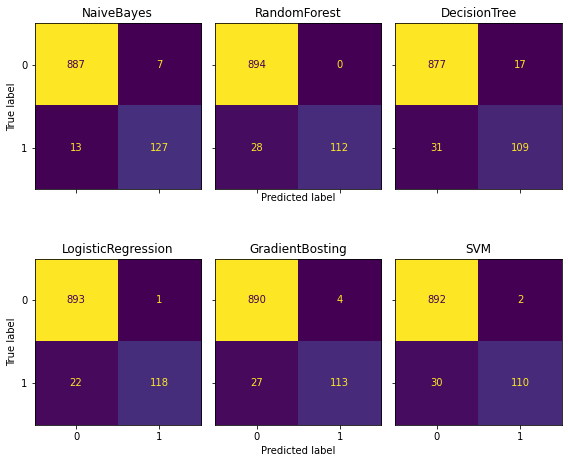

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(8, 8), sharex='col', sharey='row')
count = 0
for i in range(2):
    for j in range(3):
        disp[count].plot(ax = ax[i][j])
        disp[count].ax_.set_title(model_names[count])
        disp[count].im_.colorbar.remove()
        if j != 1:
            disp[count].ax_.set_xlabel('')
        if j != 0:
            disp[count].ax_.set_ylabel('')
        count += 1

### Curva ROC (Receiver Operating Characteristic)

In [ ]:
def plot_roc_curve(model, model_name):
    labels_pred = model.predict_proba(dtm_test)[:, 1]  # Use the probability of the positive class
    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = metrics.roc_curve(labels_test, labels_pred)

    # Calculate the Area Under the ROC Curve (AUC)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label='Curva ROC ' + model_name + '(area = {:.2f}) '.format(roc_auc))

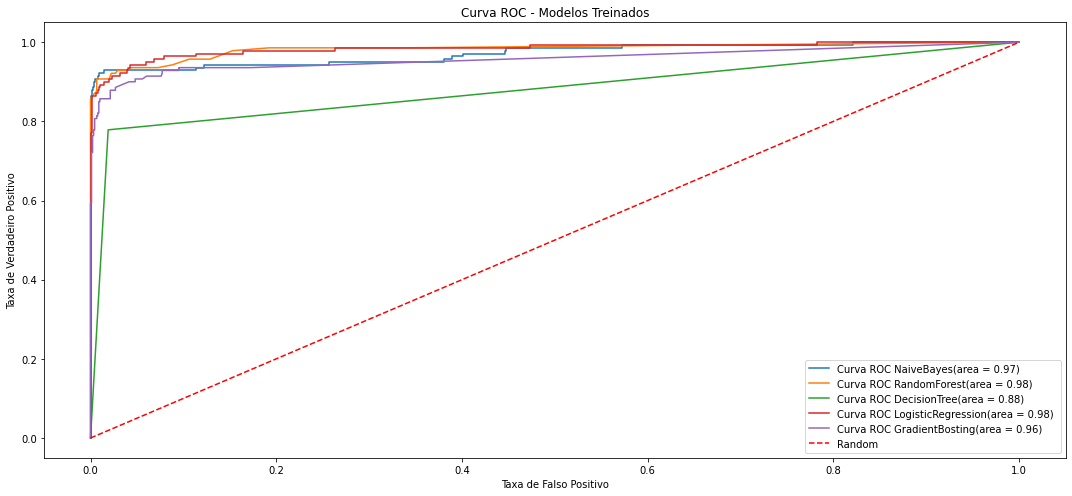

In [ ]:
plot_roc_curve(nb, model_names[0])
plot_roc_curve(rf,model_names[1])
plot_roc_curve(dt, model_names[2])
plot_roc_curve(lr, model_names[3])
plot_roc_curve(gb, model_names[4])
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC - Modelos Treinados')
plt.legend()
plt.show()

In [ ]:
def plot_precicion_recall_curve(model, model_name):
    labels_prob = model.predict_proba(dtm_test)[:, 1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(labels_test, labels_prob)
    plt.figure(figsize=(5, 3))
    plt.title('Curva Precisão-Recall - ' + model_name)
    plt.plot(precisions[:-1], recalls[:-1])
    plt.xlabel("Recalls")
    plt.ylabel("Precisão")

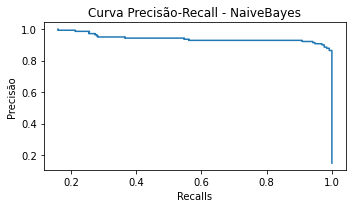

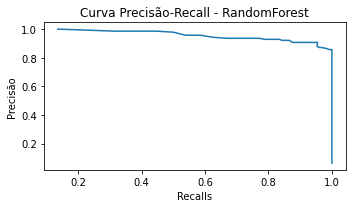

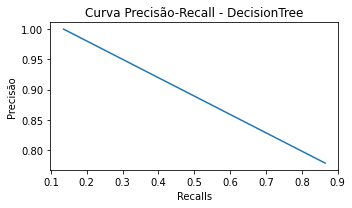

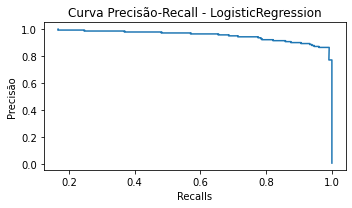

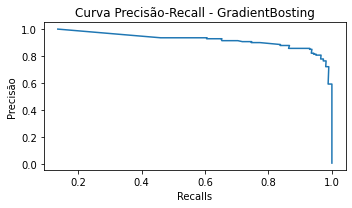

In [ ]:
plot_precicion_recall_curve(nb, model_names[0])
plot_precicion_recall_curve(rf,model_names[1])
plot_precicion_recall_curve(dt, model_names[2])
plot_precicion_recall_curve(lr, model_names[3])
plot_precicion_recall_curve(gb, model_names[4])

## Conclusão

O trabalho teve por objetivo classificar mensagens entre SPAM e HAM, tendo como elementos de entrada as mensagens fornecidas a partir da base fornecida em [SMS Spam Collection Dataset - Kaggle](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?datasetId=483).


Após treinar os modelos para classificação, os resultados foram submetidos a diferentes métricas de avaliação.
Os modelos que obtiveram o melhor desempenho nas principais métricas de avaliação foram:
* [Acurácia] Logistic Regression - Acertou o maior número de previsões
* [Precisão] Naive Bayes - Dentre os casos de SPAM, foi o que obteve maior volume de acertos na predição
* [Revocação] Random Forest - Obteve melhor êxito em predições de SPAM

A respeito dos modelos treinados, vale destacar que o Logistic Regression foi o que obteve resultados mais balanceados em todas as métricas, sendo portanto, o que melhor performou no desafio proposto.